In [1]:
#%gui wx
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
#from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
from plotting import plot_surf_stat_map
import operator
import time

/scr/ilz1/cbspython_surf/surfenv/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def make_cmap(c):
    cmap = np.asarray(sns.color_palette('Blues', c-1))
    cmap = np.concatenate((np.array([[0.8,0.8,0.8]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [4]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

### Loading and preparing data

In [5]:
hemi='rh'
embed=10
masktype='025_5'

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy'
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/rh_fullmask_%s.npy'%masktype
embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_%s/rh_embed_10.npy'%masktype
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_rh_profiles.npy'

#mesh_file = '/SCR/data/ohbm2016/lowres_rh_d.vtk'
#sulc_file = '/SCR/data/ohbm2016/lowres_rh_sulc.npy'
#mask_file = '/SCR/data/ohbm2016/rh_fullmask_%s.npy'%masktype
#embed_file='/SCR/data/ohbm2016/mask_%s/rh_embed_10.npy'%masktype
#t1_file = '/SCR/data/ohbm2016/avg_rh_profiles.npy'

In [6]:
colors = sns.color_palette('cubehelix', 10)

In [23]:
v,f,d = read_vtk(mesh_file)
mask = np.load(mask_file)
embedding = np.load(embed_file)
t1_embedding = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/profile_embedding/rh_mask_025_5_affine_embed_10.npy')
t1_profiles = np.load(t1_file)
sulc = np.load(sulc_file)

In [8]:
t1_profiles[mask]=0

In [9]:
coeff, poly = chebapprox(t1_profiles[:,3:8], 4)

In [10]:
t1_avg = np.mean(t1_profiles[:,3:8], axis=1)

#### Prepare data so that only nodes with T1 between 1500 and 2500 and Embedding != 0 are kept in both arrays

In [11]:
def graph_embed(nodes, triangles, embed):
    '''
    Creates a networkx graph from a mesh
    '''
    
    import numpy as np
    import networkx as nx
    
    # initiate empty graph
    G=nx.Graph()
    
    # add node indices
    G.add_nodes_from(range(len(nodes)))
    
    # add edges
    G.add_edges_from(triangles[:,[0,1]])
    G.add_edges_from(triangles[:,[0,2]])
    G.add_edges_from(triangles[:,[1,2]])
    
    # caution! this adds a key 'coords' to the node
    # which will also be picked up by .neighbors methods
    
    for e in G.edges_iter():
        #G[e[0]][e[1]]['length']=np.linalg.norm(nodes[e[0]]-nodes[e[1]])
        G[e[0]][e[1]]=float(embed[e[1]]-embed[e[0]])/np.linalg.norm(nodes[e[0]]-nodes[e[1]])
        G[e[1]][e[0]]=float(embed[e[0]]-embed[e[1]])/np.linalg.norm(nodes[e[0]]-nodes[e[1]])

    return G

In [24]:
G_embed = graph_embed(v, f, embedding[:,2])

In [25]:
G_myelin = graph_embed(v, f, t1_embedding[:,1])

In [28]:
G_embed[7000][6551]

-0.0029487820445115785

In [29]:
G_myelin[7000][6551]

0.023891977974731689

In [22]:
G_embed.nodes() == G_myelin.nodes()

True

In [30]:
embed_dist = []
myelin_dist = []

for node_a in G_embed.nodes_iter():
    for node_b in G_embed[node_a].keys():
        embed_dist.append(G_embed[node_a][node_b])
        myelin_dist.append(G_myelin[node_a][node_b])

In [31]:
len(embed_dist)

453246

In [35]:
embed_dist[0]

0.0

In [32]:
len(myelin_dist)

453246

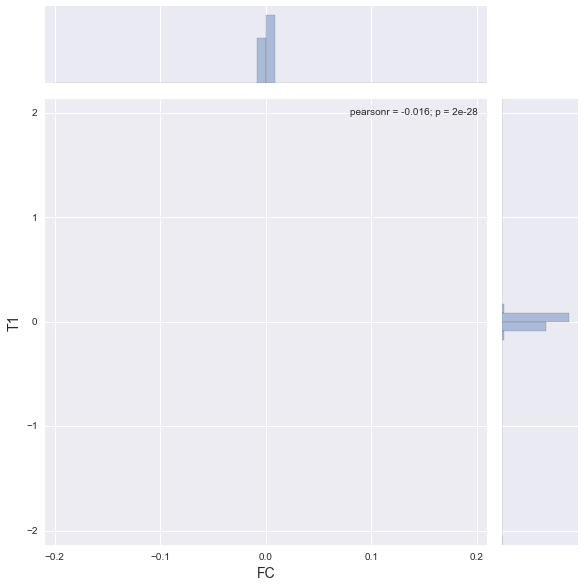

In [36]:
g = sns.jointplot(np.asarray(embed_dist), np.asarray(myelin_dist), kind="hex", size=8)
g.set_axis_labels('FC', 'T1', fontsize=14)

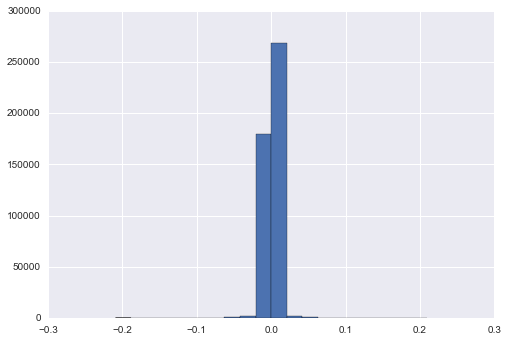

In [39]:
plt.hist(embed_dist, bins=20);

In [ ]:
embed